In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline



In [70]:
# data = pd.read_excel("data_test-1.xls", header=26, skiprows=0)
raw_data = pd.read_excel("python_data.xls")
data = raw_data.copy()




## Cleaning Data

In [71]:
data = data.dropna(axis=1, how='all').dropna(axis=0, how='all')

In [72]:
# removing any unnamed columns
for col in data.columns:
    if 'Unnamed' in col:
        del data[col]

In [73]:
data = data[data['MAT $ 2012'] != 0]
data = data[data['MAT $ 2013'] != 0]
data = data[data['MAT $ 2014'] != 0]


## Adding Features

In [74]:
# mean of occ cost % over 3 years
data['avg_occ_3yrs'] = data[['MAT Occ Cost % 2012', 'MAT Occ Cost % 2013', \
                                     'MAT Occ Cost % 2014']].apply(np.sum, axis=1)/3

In [75]:
imp_feat_list = ['Lease', 'MAT $ CAGR ', 'MAT $ (mo. slope) ', 'avg_occ_3yrs', 'MAT $ PSF Var_Avg ', 'MAT $ PSF Var_slope ', \
                'MAT Occ Cost % (slope) ', 'MAT Occ Cost % CAGR ', 'MAT Occ Cost % CAGR to MAT $ Var ', 'MAT Occ Cost %_Avg_Var _2014',\
                'MAT Occ Cost %_1yr_slope _', 'MAT Occ Cost %_2yr_slope _', 'Month $ PSF % Var_1yr_avg _', 'Month $ PSF % Var_2yr_avg _',\
                'Month $ PSF % Var (1 yr. slope) _', 'Month $ PSF % Var (2 yr. slope) _', 'Non-Holiday Month % Var _2014', \
                'Holiday Month % Var _2014', 'Lease Term (mo.)', 'AR_Past_Due_MAX', 'AR_% of Billings Owed_MAX', \
                'AR_61 - 90_MAX', 'AR_Over 90_MAX', 'AR_2monthover_MAX', 'Defaulted']

In [76]:
data.head()

,Lease,Space,Product Category,Space Type,Shop Count 2014,Area 2014,MAT $ 2012,MAT $ 2013,MAT $ 2014,MAT $ CAGR,...,AR_2monthover_6-14,AR_Past_Due_MAX,AR_1 - 30_MAX,AR_31 - 60_MAX,AR_61 - 90_MAX,AR_Over 90_MAX,AR_MTD Billings_MAX,AR_% of Billings Owed_MAX,AR_2monthover_MAX,avg_occ_3yrs
0,37247,0112234 1000,SF21 US Food Service,"In-Line Units 0-9,999 SF",0,0,221541.00,211611.00,22000.00,-0.536920,...,0,18709.21,8473.31,0.00,9382.91,852.99,8473.31,2.208017,1,0.530058
1,27469,0112243 O358,SF11 US Food Court,"Food Court 0-9,999 SF",0,0,207989.00,167542.22,13407.00,-0.599044,...,0,24478.59,6809.72,0.00,9528.30,8140.57,6809.72,3.594654,1,0.549648
2,51346,0112253 FC6,SF11 US Food Court,"Food Court 0-9,999 SF",0,0,231957.00,216441.00,15200.00,-0.596839,...,0,17163.71,7464.11,0.00,7461.24,2238.36,7464.11,2.299499,1,0.565102
3,342043,0112327 218,S111 US Women's Fashion,"In-Line Units 0-9,999 SF",0,0,639872.06,598754.70,101942.13,-0.457891,...,0,21098.70,19213.71,0.00,0.00,1884.99,19213.71,1.098107,1,0.414918
4,20935,0112230 E2,S111 US Women's Fashion,"In-Line Units 0-9,999 SF",0,0,749929.89,731330.94,134231.48,-0.436434,...,1,-18100.27,0.00,-42331.17,6451.03,17779.87,0.00,0.000000,1,0.183486


In [77]:
data.shape

(1519, 236)

### Parsing Out Inline Tenants

In [78]:
INL_data = data[data['Lease Space Type-Calc'] == 'INL']
# below code if i want to include multiple tenant types
# stk_list = ['INL']
# INL_data = [data['Lease Space Type-Calc'].isin(stk_list)]
INL_data.shape

(1167, 236)

### % of tenants that have defaulted within Inline dataset

In [79]:
INL_DEF_Tenants = INL_data[INL_data['Defaulted'] == 1]
print("Number of leases in dataset: ", len(INL_data))
print("Number of defaulted leases in dataset: ", len(INL_DEF_Tenants))
default_percent = "{:.2f}%".format(len(INL_DEF_Tenants)/len(INL_data))  # percent of defaulted tenants in inline dataset
print("Percent of defaulted: ", default_percent)

Number of leases in dataset:  1167
Number of defaulted leases in dataset:  87
Percent of defaulted:  0.07%


In [80]:
## sorts which malls have greatest number of defaults
pop_mall_defs = INL_data['BU Number-E1'].max()
print(pop_mall_defs)
INL_data[INL_data['BU Number-E1'] == pop_mall_defs]
print("Greatest number of defaults per mall is 2")


12327
Greatest number of defaults per mall is 2


## Logistic Regression Analysis

### SciKit Learn - Logistic Regression

In [81]:
# Import Logistic Regression & Linear regression libraries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score


In [82]:
## create data for logarithmic regression analysis
# log_list choooses categories I want to include in analysis
log_list = imp_feat_list
log_data = INL_data[log_list].copy()  # make sure to make copy so it's more than reference
log_data = log_data.drop('Lease', axis=1)  # drop lease from log_data
log_data = log_data.dropna(axis=0)  # remove any blank values from dataframe

In [83]:
log_data_X = log_data.drop('Defaulted', axis=1)  # remove defaulted column from dataframe
log_X = log_data_X.values  # turn datatable into array
log_y = log_data['Defaulted']  

In [84]:
# Fit logistic regression model
X_train_log, X_test_log, y_train_log, y_test_log = cross_validation.train_test_split(log_X, log_y, test_size=.5, random_state=0)

lr = LogisticRegression()
lr.fit(X_train_log, y_train_log)



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [85]:
lr.coef_
sorted(list(zip(lr.coef_[0], log_data_X.columns)))  # pull most weighted coefficients with respective feature name

[(-0.43674828057440285, 'avg_occ_3yrs'),
 (-0.41348851867584085, 'AR_2monthover_MAX'),
 (-0.34577820745619731, 'MAT $ PSF Var_Avg '),
 (-0.22527413600790766, 'MAT Occ Cost % CAGR '),
 (-0.15866550243646435, 'MAT $ CAGR '),
 (-0.14139598658633973, 'Holiday Month % Var _2014'),
 (-0.098867815526809649, 'MAT Occ Cost %_Avg_Var _2014'),
 (-0.080069932519499412, 'Month $ PSF % Var_2yr_avg _'),
 (-0.042081426401296758, 'MAT Occ Cost % (slope) '),
 (-0.033414375727298738, 'Month $ PSF % Var_1yr_avg _'),
 (-0.019826559582414034, 'Lease Term (mo.)'),
 (-0.011370759172705918, 'Month $ PSF % Var (1 yr. slope) _'),
 (-0.0070223623432581284, 'MAT Occ Cost %_1yr_slope _'),
 (-0.0042120511634653303, 'MAT Occ Cost %_2yr_slope _'),
 (-4.5160576035973779e-06, 'AR_Over 90_MAX'),
 (-4.505897868154408e-06, 'MAT $ (mo. slope) '),
 (-1.1968256959694415e-06, 'AR_Past_Due_MAX'),
 (6.468442998330709e-05, 'AR_61 - 90_MAX'),
 (0.0049494180141018826, 'Month $ PSF % Var (2 yr. slope) _'),
 (0.0068528425349839552, '

In [86]:
cross_val_score(lr, X_test_log, y_test_log)  # compares results of model to actual results

array([ 0.91282051,  0.90769231,  0.92227979])

In [87]:
log_prob = lr.predict_proba(log_X)[:, 1]  # returns the probability
# print(log_prob)
log_pred_y = lr.predict(log_X)
list(zip(log_y, log_pred_y, log_prob))

[(1, 0, 0.38571553012588877),
 (1, 0, 0.13344298207438426),
 (1, 0, 0.23765002563774743),
 (1, 0, 0.25504201334315008),
 (1, 0, 0.066491262947806148),
 (1, 0, 0.14713779518673631),
 (1, 0, 0.076174943831527744),
 (1, 0, 0.05797784563269999),
 (1, 0, 0.24795923610740275),
 (1, 0, 0.033452290768870109),
 (1, 0, 0.23747700413447467),
 (1, 0, 0.38933579559385895),
 (1, 1, 0.98612179709784087),
 (1, 0, 0.022834722311802457),
 (1, 0, 0.16617715152938409),
 (1, 0, 0.0092192016688581128),
 (1, 0, 0.057537818296403094),
 (1, 0, 0.039815739831116588),
 (1, 0, 0.029684248508964946),
 (1, 0, 0.016379435486307801),
 (1, 0, 0.052686644333929382),
 (1, 0, 0.15672825788812483),
 (1, 0, 0.35904798261644982),
 (1, 0, 0.16814910778187031),
 (1, 0, 0.048617798858046957),
 (1, 0, 0.025958101852975764),
 (1, 0, 0.024082332772335492),
 (1, 0, 0.033921051988557736),
 (1, 0, 0.10462083599807859),
 (1, 0, 0.062197127170947573),
 (1, 0, 0.14418263722406252),
 (1, 0, 0.21869603623021519),
 (1, 0, 0.02816030809133

### Stats Models - Logistic Regression Analysis

In [88]:
# Statsmodel APIs
import statsmodels.api as sm
import statsmodels.formula.api as smf  # uses R style formulas


In [91]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = cross_validation.train_test_split(log_X, log_y, test_size=.5, random_state=1)

X_train = sm.add_constant(X_train_sm)
model = sm.Logit(y_train_sm, X_train_sm)
results = model.fit()


Optimization terminated successfully.
         Current function value: 0.190513
         Iterations 12


In [92]:
cross_val_score(lr, X_test_sm, y_test_sm)

array([ 0.94358974,  0.94358974,  0.94300518])

In [93]:
results = smf.Logit(log_y, log_X, data=log_data).fit()

Optimization terminated successfully.
         Current function value: 0.192790
         Iterations 16


In [94]:
print(results.summary())

                           Logit Regression Results                           
Dep. Variable:              Defaulted   No. Observations:                 1166
Model:                          Logit   Df Residuals:                     1144
Method:                           MLE   Df Model:                           21
Date:                Thu, 05 Nov 2015   Pseudo R-squ.:                  0.2736
Time:                        17:56:44   Log-Likelihood:                -224.79
converged:                       True   LL-Null:                       -309.47
                                        LLR p-value:                 3.426e-25
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.2910        nan        nan        nan           nan       nan
x2          2.628e-06   1.58e-06      1.663      0.096      -4.7e-07  5.73e-06
x3            -6.2186      0.953     -6.524      0.0

In [95]:
sorted(list(zip(results.params, log_data_X.columns)))

[(-43.191871143819732, 'Month $ PSF % Var (2 yr. slope) _'),
 (-18.722251701399852, 'Month $ PSF % Var_2yr_avg _'),
 (-15.962821844417935, 'MAT Occ Cost %_2yr_slope _'),
 (-6.2186314406379006, 'avg_occ_3yrs'),
 (-3.8831440112877629, 'MAT Occ Cost %_1yr_slope _'),
 (-3.06714261848215, 'Non-Holiday Month % Var _2014'),
 (-2.7397667269266401, 'MAT Occ Cost % CAGR '),
 (-0.99824741325193567, 'Holiday Month % Var _2014'),
 (-0.21994394669293074, 'Month $ PSF % Var (1 yr. slope) _'),
 (-0.024819824163078263, 'Lease Term (mo.)'),
 (-2.6574771583356295e-06, 'AR_Over 90_MAX'),
 (2.6279964678157864e-06, 'MAT $ (mo. slope) '),
 (1.7307369521562853e-05, 'AR_Past_Due_MAX'),
 (3.2001193720531323e-05, 'AR_61 - 90_MAX'),
 (0.015499519745420789, 'AR_% of Billings Owed_MAX'),
 (0.029149380733378548, 'AR_2monthover_MAX'),
 (0.29099764523101507, 'MAT $ CAGR '),
 (0.47227821582155899, 'MAT $ PSF Var_Avg '),
 (0.7696040763073847, 'MAT $ PSF Var_slope '),
 (0.90231699849388736, 'MAT Occ Cost %_Avg_Var _2014'

# Random Forrest analysis

In [108]:
# import libraries

from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import DecisionTree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import cross_val_score
from matplotlib import pyplot as plt



# Set a random seed.
rng = np.random.RandomState(0)

## try out test, train split b/c high accuracy score

In [97]:
tree_list = imp_feat_list
tree_data = data[tree_list].copy()  # make sure to make copy so it's more than reference
tree_data = tree_data.drop('Lease', axis=1)
tree_data = tree_data.dropna(axis=0)
tree_data_X = tree_data.drop('Defaulted', axis=1)


In [98]:
tree_X = tree_data_X.values
tree_y = tree_data['Defaulted']
# tree_data

In [99]:
# splitting data so as to avoid overfitting
X_train_tree, X_test_tree, y_train_tree, y_test_tree = cross_validation.train_test_split(tree_X, \
                                                                                         tree_y, \
                                                                                         test_size=.5, \
                                                                                         random_state=1)

In [100]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(tree_X, tree_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [152]:
# to research

cross_val_score(rf, tree_X, tree_y)

array([ 0.95833333,  0.9582505 ,  0.98409543])

In [104]:
tree_pred_y = rf.predict(tree_X)

In [105]:
list(zip(tree_y, tree_pred_y))

[(1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 

## find important classifiers

In [153]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")


# variables for graph input
rand_imp_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rand_imp_feats = []
rand_imp_featnums = []

for f in range(10):
    
    # appending feature names to rand_imp_feats list
    feats = tree_data_X.columns[indices[f]]
    rand_imp_feats.append(feats)
    # appending feature values to rand_imp_featnums list
    featnums = importances[indices[f]]
    rand_imp_featnums.append(featnums)

    print("%d. feature %s (%f)" % (f + 1, tree_data_X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature Month $ PSF % Var (1 yr. slope) _ (0.078192)
2. feature AR_Past_Due_MAX (0.075198)
3. feature Holiday Month % Var _2014 (0.073636)
4. feature MAT Occ Cost % CAGR  (0.072122)
5. feature AR_% of Billings Owed_MAX (0.055302)
6. feature Month $ PSF % Var_2yr_avg _ (0.052659)
7. feature MAT $ CAGR  (0.049626)
8. feature MAT $ PSF Var_Avg  (0.045811)
9. feature AR_61 - 90_MAX (0.045383)
10. feature Non-Holiday Month % Var _2014 (0.044052)


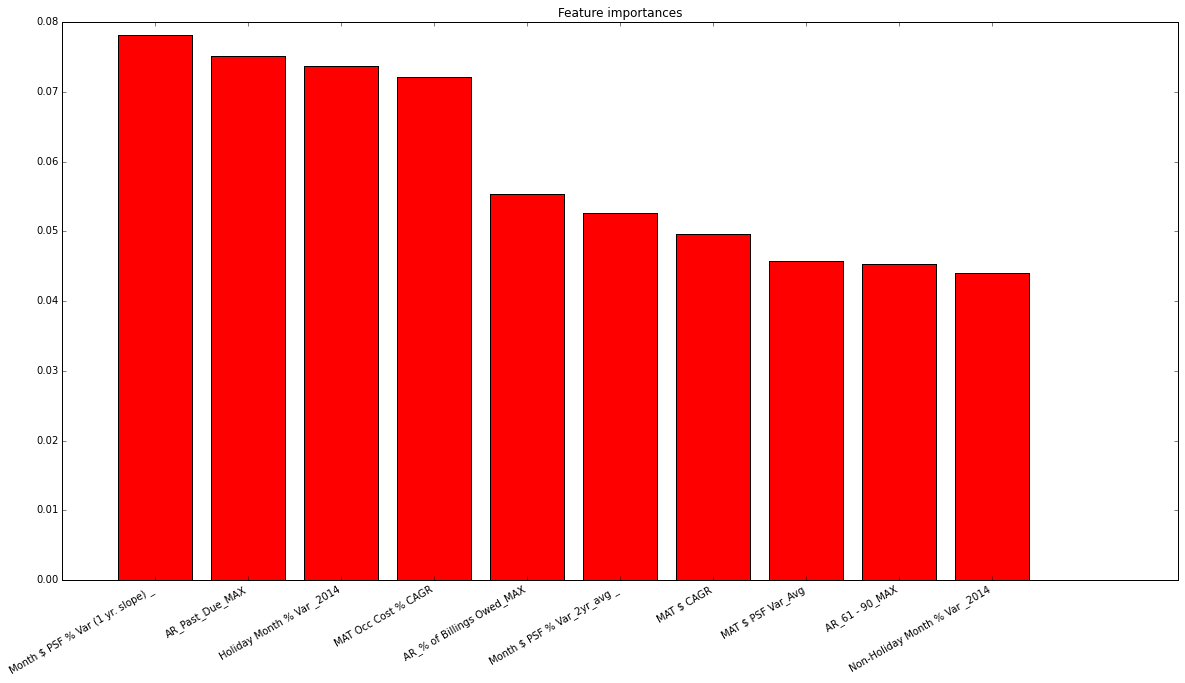

In [151]:
# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(rand_imp_range, rand_imp_featnums,
       color="r", align="center")
plt.xticks(rand_imp_range, rand_imp_feats, rotation=30, ha='right')
plt.show()




## K-means Clustering

In [158]:
# import kmeans libraries
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist

In [206]:
## create data for K-means clustering analysis
# k_list choooses categories I want to include in analysis
k_list = imp_feat_list
kmdata = INL_data[k_list].copy()  # make sure to make copy so it's more than reference
kmdata = kmdata.drop('Lease', axis=1)  # drop lease from log_data
kmdata = kmdata.dropna(axis=0)  # remove any blank values from dataframe

In [207]:
kmdata_X = kmdata.drop('Defaulted', axis=1)  # remove defaulted column from dataframe
kmdata_X = kmdata_X.values  # turn datatable into array
kmdata_y = k_data['Defaulted']  

In [222]:
##### cluster data into K=1..10 clusters #####
#K, KM, centroids,D_k,cIdx,dist,avgWithinSS = kmeans.run_kmeans(X,10)

K = range(1,10)

  # scipy.cluster.vq.kmeans
KM = [kmeans(kmdata_X,k) for k in K] # apply kmeans 1 to 10
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(kmdata_X, cent, 'euclidean') for cent in centroids]

cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/kmdata_X.shape[0] for d in dist]

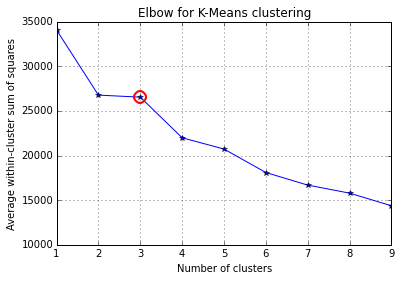

In [223]:
kIdx = 2
# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')  

In [258]:
from sklearn.cluster import KMeans
km = KMeans(3, init='k-means++') # initialize
km.fit(kmdata_X)
c = km.predict(kmdata_X) # classify into three clusters

## Add cluster feature to data table

In [259]:
kmdata['cluster_num'] = c
kmdata.head()

,MAT $ CAGR,MAT $ (mo. slope),avg_occ_3yrs,MAT $ PSF Var_Avg,MAT $ PSF Var_slope,MAT Occ Cost % (slope),MAT Occ Cost % CAGR,MAT Occ Cost % CAGR to MAT $ Var,MAT Occ Cost %_Avg_Var _2014,MAT Occ Cost %_1yr_slope _,...,Non-Holiday Month % Var _2014,Holiday Month % Var _2014,Lease Term (mo.),AR_Past_Due_MAX,AR_% of Billings Owed_MAX,AR_61 - 90_MAX,AR_Over 90_MAX,AR_2monthover_MAX,Defaulted,cluster_num
0,-0.536920,-8314.208333,0.530058,0.253150,-1.237991,0.138618,-0.454754,-0.082166,0.064761,0.011526,...,-0.862497,-1,12.033333,18709.21,2.208017,9382.91,852.99,1,1,0
3,-0.457891,-22413.747083,0.414918,-0.262892,-0.440971,0.110039,-0.358204,-0.099687,0.390923,0.013769,...,-0.800497,-1,41.533333,21098.70,1.098107,0.00,1884.99,1,1,0
4,-0.436434,-25654.100417,0.183486,-0.304166,-0.343184,-0.020467,-0.475295,0.038861,-0.222841,0.000036,...,-0.779113,-1,10.100000,-18100.27,0.000000,6451.03,17779.87,1,1,0
15,-0.090025,-10131.894583,0.260238,-0.092193,-0.108304,-0.090482,-0.290271,0.200246,-0.390786,-0.010605,...,-0.060188,-1,3.733333,4935.36,0.328955,0.00,0.00,0,1,0
16,-0.054611,-5258.561250,0.318355,-0.022709,-0.132888,-0.051341,-0.154679,0.100068,-0.141812,-0.010660,...,0.029807,-1,69.833333,7449.47,0.286865,-1252.84,0.00,0,1,0


In [261]:
kmdata[kmdata['cluster_num'] == 0]

,MAT $ CAGR,MAT $ (mo. slope),avg_occ_3yrs,MAT $ PSF Var_Avg,MAT $ PSF Var_slope,MAT Occ Cost % (slope),MAT Occ Cost % CAGR,MAT Occ Cost % CAGR to MAT $ Var,MAT Occ Cost %_Avg_Var _2014,MAT Occ Cost %_1yr_slope _,...,Non-Holiday Month % Var _2014,Holiday Month % Var _2014,Lease Term (mo.),AR_Past_Due_MAX,AR_% of Billings Owed_MAX,AR_61 - 90_MAX,AR_Over 90_MAX,AR_2monthover_MAX,Defaulted,cluster_num
0,-0.536920,-8314.208333,0.530058,0.253150,-1.237991,0.138618,-0.454754,-0.082166,0.064761,0.011526,...,-0.862497,-1.000000,12.033333,18709.21,2.208017,9382.91,852.99,1,1,0
3,-0.457891,-22413.747083,0.414918,-0.262892,-0.440971,0.110039,-0.358204,-0.099687,0.390923,0.013769,...,-0.800497,-1.000000,41.533333,21098.70,1.098107,0.00,1884.99,1,1,0
4,-0.436434,-25654.100417,0.183486,-0.304166,-0.343184,-0.020467,-0.475295,0.038861,-0.222841,0.000036,...,-0.779113,-1.000000,10.100000,-18100.27,0.000000,6451.03,17779.87,1,1,0
15,-0.090025,-10131.894583,0.260238,-0.092193,-0.108304,-0.090482,-0.290271,0.200246,-0.390786,-0.010605,...,-0.060188,-1.000000,3.733333,4935.36,0.328955,0.00,0.00,0,1,0
16,-0.054611,-5258.561250,0.318355,-0.022709,-0.132888,-0.051341,-0.154679,0.100068,-0.141812,-0.010660,...,0.029807,-1.000000,69.833333,7449.47,0.286865,-1252.84,0.00,0,1,0
17,-0.069938,-10359.169583,0.169182,-0.044269,-0.136337,-0.037092,-0.191306,0.121367,-0.056973,-0.000830,...,0.032867,-1.000000,24.700000,7645.24,0.167652,-3256.98,-17115.98,0,1,0
18,-0.052913,-7352.492083,0.406484,-0.074639,-0.065161,0.011566,-0.031497,-0.021416,-0.049952,-0.016961,...,0.092756,-1.000000,27.700000,12946.58,0.248898,-4414.14,22.21,1,1,0
20,-0.073552,-8999.792917,0.268089,-0.026869,-0.137257,-0.035692,-0.157816,0.084264,-0.103888,-0.010880,...,0.081995,-1.000000,63.600000,9164.52,0.341235,0.00,212.22,1,1,0
21,-0.101871,-13479.458750,0.246454,-0.119920,-0.100080,-0.005016,-0.112223,0.010352,0.221935,0.009592,...,-0.047741,-1.000000,6.133333,60961.49,1.642417,0.00,18065.90,1,1,0
22,-0.406602,-15226.847917,0.435558,-0.302278,-0.304101,0.124327,-0.287356,-0.119246,0.242041,0.012621,...,-0.712314,-1.000000,82.133333,45289.56,0.000000,719.00,30187.14,1,1,0
